In [1]:
#JV

In [2]:
import numpy as np

import pandas as pd

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from torch.utils.data import Dataset,TensorDataset, DataLoader, RandomSampler
from torch.nn.utils.rnn import pad_sequence
import random

import os
import gc
import time
import math

import matplotlib.pyplot as plt
#plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np

from tqdm.notebook import tqdm

In [3]:
seed = 23

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

In [4]:
class LanguageProcessor:

    def __init__(self,language_directory,target_lang_name,mode="train",meta_tokens=True):

        """
        Default Constructor for this class.

        Params:

            language_directory : ex : "aksharantar_sampled/tel/"
            mode : "train" or "test" or "valid", accordingly the appropriate dataset is read.
            meta_tokens : If true creates the first three tokens of the dictionary as <start>,<end>,<pad>.
            
        """

        self.meta_tokens = meta_tokens ## boolean variable, if 1, then <start>,<end> and <pad> tokens are cosidered in the vocab.
        self.language_directory = language_directory
        self.target_lang_name = target_lang
        self.mode = mode ## accordingly helps to read and generate the appropriate dataset.
    
        self.source_lang = 0
        self.target_lang = 1

        self.source_max_len = self.find_max_len(self.source_lang)
        self.target_max_len = self.find_max_len(self.target_lang)

        self.max_len = max(self.source_max_len,self.target_max_len)+1 ##accomodating End token also, irrespective of whether it is used.

        self.source_char2id,self.source_id2char = self.build_char_vocab(self.source_lang,self.source_max_len)
        self.target_char2id,self.target_id2char = self.build_char_vocab(self.target_lang,self.target_max_len)


    def find_max_len(self,lang):

        """
        Method to find the maximum length of a word across train/test and validation data.

        This would help in padding, the embedding accordingly.

        Params:

            lang : 0/1 (source/target) language for which the length of the longest word must be found.
        
        """

        train_df = pd.read_csv(self.language_directory+self.target_lang_name+"_train.csv",header=None)
        test_df = pd.read_csv(self.language_directory+self.target_lang_name+"_test.csv",header=None)
        valid_df = pd.read_csv(self.language_directory+self.target_lang_name+"_valid.csv",header=None)

        train_max_len = len(max(list(train_df[lang]), key = len))
        test_max_len = len(max(list(test_df[lang]), key = len))
        valid_max_len = len(max(list(valid_df[lang]), key = len))

        del train_df
        del test_df
        del valid_df

        gc.collect()

        return max(train_max_len,test_max_len,valid_max_len)

    def build_char_vocab(self,lang_id,max_len=None):

        """
        Method to create a vocabulary of characters in language corresponding to lang_id.
        """

        df = pd.read_csv(self.language_directory+self.target_lang_name+"_"+self.mode+".csv",header=None)

        self.data = df.to_numpy()

        lang_chars = []
        lang_words = df[lang_id].to_numpy()
    
        for word in lang_words:
            lang_chars += list(word)
    
        unique_lang_chars =  sorted(list(set(lang_chars)))
        
        if self.meta_tokens:
            char2id_dict = {'<start>':0,'<end>':1,'<pad>': 2}
            id2char_dict = {0:'<start>',1:'<end>',2:'<pad>'}
            
        else:
            char2id_dict = {}
            id2char_dict = {}

        start = len(char2id_dict) ##Key of each language character starts based on meta tokens are used or not.
    
        for i in range(len(unique_lang_chars)):
            char2id_dict[unique_lang_chars[i]] = i+start
            id2char_dict[i+start] = unique_lang_chars[i]
    
        del df
        del lang_chars
        del unique_lang_chars

        gc.collect()
    
        return char2id_dict,id2char_dict

    def encode_word(self,word,lang_id,padding=True,append_eos = True):

        """
        Method to encode characters of a given word.

        Params:

            word: The word to be encoded.
            lang_id : 0/1 for source/target lang.
            padding : If true, the word encoding would be padded upto max len.
            append_eos : Appends <end> token at the end of every word.
        
        """

        if lang_id == self.source_lang:
            char2id_dict = self.source_char2id
            
        else:
            char2id_dict = self.target_char2id
        
        max_len = self.max_len

        word_encoding = []
        
        #if lang_id == self.source_lang:
        #    word_encoding = [char2id_dict['<start>']] ##every input starts with the <start> token.
        
        for i in word.lower():
            word_encoding.append(char2id_dict[i])

        #if append_eos:
        #    word_encoding.append(char2id_dict['<end>'])

        ## pad till maxlen, if padding is used.
        if padding:
            word_encoding += [char2id_dict['<pad>']] * (max_len - len(word_encoding))
        
        return np.array(word_encoding)

    def decode_word(self,code_word,lang_id):

        """
        Method to decode an encoded word.

        Params:

            code_word : The encoded word.
            lang_id : 0/1 for source/target lang.
        """
    
        word = []

        if lang_id == self.source_lang:
            id2char_dict = self.source_id2char
            char2id_dict = self.source_char2id
            
        else:
            id2char_dict = self.target_id2char
            char2id_dict = self.target_char2id

        start_idx = 0#1-lang_id
        
        for i in code_word[start_idx:]:
            ## if we reached <end>, then stop decoding
            if self.meta_tokens and i == char2id_dict['<end>'] or i == char2id_dict['<pad>']:
                break
            
            word.append(id2char_dict[i])
            
        return np.array(word)
            

In [5]:
class WordDataset(Dataset):

    """
    Class that inherits and overrides the methods of Dataset class. This helps in creating a data loader.
    """
    
    def __init__(self, language_processor,append_eos=True,device='cpu'):

        self.lp = language_processor
        self.data = self.lp.data
        self.device = device
        self.append_eos = append_eos

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        input_word, output_word = self.data[idx]
        
        input_sequence = self.lp.encode_word(input_word,self.lp.source_lang,padding=False,append_eos=self.append_eos)
        output_sequence = self.lp.encode_word(output_word,self.lp.target_lang,padding=False,append_eos=self.append_eos)
        

        #if len(input_sequence) != len(output_sequence):
        #    print(input_word,len(input_word),output_word,len(output_word))
        
        return torch.tensor(input_sequence).to(device), torch.tensor(output_sequence).to(device)
        #return input_sequence, output_sequence


In [6]:
def collate_fn(batch):
    
    input_words, target_words = zip(*batch)
    
    padded_inputs = pad_sequence(input_words, batch_first=True, padding_value=pad_token_id)
    
    padded_targets = pad_sequence(target_words, batch_first=True, padding_value=pad_token_id)
    
    input_lengths = torch.LongTensor([len(seq) for seq in input_words]).to(device)
    target_lengths = torch.LongTensor([len(seq) for seq in target_words]).to(device)
    
    return padded_inputs, padded_targets, input_lengths, target_lengths

In [7]:
batch_size = 64

base_dir = "aksharantar_sampled/"
target_lang = "tel"

use_meta_tokens = True
append_eos = 1

lang_dir = base_dir + target_lang + "/"

In [8]:
device = torch.device("mps")

##creating train loader
train_lp = LanguageProcessor(language_directory=lang_dir,target_lang_name=target_lang,mode="train",meta_tokens=use_meta_tokens)
train_dataset = WordDataset(train_lp,device=device)
train_loader = DataLoader(train_dataset, batch_size=batch_size,collate_fn=collate_fn, shuffle=True)

## creating test loader
test_lp = LanguageProcessor(language_directory=lang_dir,target_lang_name=target_lang,mode="test",meta_tokens=use_meta_tokens)

## to make sure that the same vocabulary and dictionaries are used everywhere
test_lp.source_char2id = train_lp.source_char2id
test_lp.source_id2char = train_lp.source_id2char
test_lp.target_char2id = train_lp.target_char2id
test_lp.target_id2char = train_lp.target_id2char

test_dataset = WordDataset(test_lp,device=device)
test_loader = DataLoader(test_dataset, batch_size=batch_size,collate_fn=collate_fn, shuffle=True)

## creating validation loader
valid_lp = LanguageProcessor(language_directory=lang_dir,target_lang_name=target_lang,mode="valid",meta_tokens=use_meta_tokens)
valid_lp.source_char2id = train_lp.source_char2id
valid_lp.source_id2char = train_lp.source_id2char
valid_lp.target_char2id = train_lp.target_char2id
valid_lp.target_id2char = train_lp.target_id2char

valid_dataset = WordDataset(valid_lp,device=device)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size,collate_fn=collate_fn, shuffle=True)

In [9]:
##in principle these are all fixed across train/test/valid data

## the ids of these tokens are the same in the source and target language
start_token_id = train_lp.source_char2id['<start>']
end_token_id = train_lp.source_char2id['<end>']
pad_token_id = train_lp.source_char2id['<pad>']

#source_max_len = train_lp.source_max_len
#target_max_len = train_lp.target_max_len

In [10]:
## Verifying if the dataloaders are carrying data correctly.
count = 0
for data in train_loader:

    inp,tar,_,_ = data

    inp = inp.view(batch_size,-1).cpu().numpy()
    tar = tar.view(batch_size,-1).cpu().numpy()

    for i in range(min(batch_size,5)):
        print("".join(list(train_lp.decode_word(inp[i],0))),"".join(list(train_lp.decode_word(tar[i],1))))

    break

hastakalarupalu హస్తకళారూపాలు
chintinchuvaadu చింతించువాడు
vraaseddaamani వ్రాసేద్దామని
gundichadevi గుండిచాదేవి
niyamichaalani నియమిచాలని


In [11]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size,padding_idx = None ,dropout_p=0.1,num_layers = 1,bidirectional = False):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size,padding_idx = padding_idx)
        self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True,num_layers = num_layers,bidirectional = bidirectional)
        self.dropout = nn.Dropout(dropout_p)

    def forward(self, input):
        embedded = self.dropout(self.embedding(input))
        output, hidden = self.gru(embedded)
        
        return output, hidden

In [12]:
class DecoderRNN(nn.Module):
    
    def __init__(self, hidden_size, output_size,max_len,start_token_id,padding_idx = None,num_layers = 1,bidirectional = False):
        super(DecoderRNN, self).__init__()
        
        self.num_layers = num_layers
        self.D = 1 ##the number of directions in which the input is viewed.
        if bidirectional:
            self.D = 2

        ## In h0 (the input to the decoder) first dimension expected is number of directions X number of layers 
        self.expected_h0_dim1 = self.D*self.num_layers

        self.embedding = nn.Embedding(output_size, hidden_size,padding_idx = padding_idx)
        self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True,num_layers = num_layers,bidirectional = bidirectional)
        self.out = nn.Linear(hidden_size*self.D, output_size)
        #self.max_len = max_len
        self.start_token_id = start_token_id

    def forward(self, encoder_outputs, encoder_hidden, target_tensor,eval_mode = False,teacher_forcing_ratio=0):
        
        batch_size = encoder_outputs.size(0)
        if not eval_mode:
            max_len = target_tensor.size(1)

        ## eval mode is for explicitly looking at the word that is predicted to compare with the correct word.
        if eval_mode:
            batch_size = 1
            max_len = 28

        ## TRY : adding requires_grad = True in torch.empty
        #decoder_input = torch.empty(batch_size, 1, dtype=torch.long, device=device).fill_(-1)
        decoder_input = torch.zeros((batch_size, 1), dtype=torch.long, device=device)#.fill_(-1)
        decoder_hidden = encoder_hidden ## in the first time step of the decoder, the output of the encoder is the input.
        decoder_outputs = []

        for i in range(max_len):
            ## print(i,self.max_len)
            decoder_output, decoder_hidden  = self.forward_step(decoder_input, decoder_hidden,eval_mode)
            #print(f"Step{i}\t Input:{decoder_input.shape}\t State:{decoder_hidden.shape}\tOutput:{decoder_output.shape}\t")
            ## print(decoder_output.shape)
            decoder_outputs.append(decoder_output)

            teacher_force = random.random() < teacher_forcing_ratio

            if (target_tensor is not None) and (teacher_force):
                # Teacher forcing: Feed the target as the next input
                decoder_input = target_tensor[:, i].unsqueeze(1) # Teacher forcing
            else:
                # Without teacher forcing: use its own predictions as the next input
                _, topi = decoder_output.topk(1)
                decoder_input = topi.squeeze(-1).detach()  # detach from history as input

        decoder_outputs = torch.cat(decoder_outputs, dim=1)
        decoder_outputs = F.log_softmax(decoder_outputs, dim=-1)
        return decoder_outputs, decoder_hidden, None # We return `None` for consistency in the training loop

    def forward_step(self, input, hidden,eval_mode):

        #print(hidden.unsqueeze(0).shape)
        if eval_mode:
            input = input.view(1,-1)

        
        output = self.embedding(input)

        #print(hidden.shape)

        if hidden.shape[0] != self.expected_h0_dim1:
            reshaped_hidden = hidden.repeat(self.expected_h0_dim1,1,1)
        else:
            reshaped_hidden = hidden

        #print("In DC",hidden.shape,reshaped_hidden.shape)
        
        #print(output.shape,output.unsqueeze(0).shape,output.unsqueeze(0).transpose(0,1).shape)

        #print("In DC INP:",input.shape)
        #print("In DC HS:",reshaped_hidden.shape)
        
        output = F.relu(output)
        output, hidden = self.gru(output, reshaped_hidden)
        #print(output.shape)
        #print("Yo1")
        output = self.out(output.squeeze(0))
        #print("Yo2")
        return output, hidden

In [13]:
"""
One thing to take care of:

    In encoder we set no grad for pad token in nn.Embed
    
    In decoder, 
        => need to see what to do after actual word is generated. How to deal with padding?

"""

'\nOne thing to take care of:\n\n    In encoder we set no grad for pad token in nn.Embed\n    \n    In decoder, \n        => need to see what to do after actual word is generated. How to deal with padding?\n\n'

In [14]:
def train_epoch(dataloader, encoder, decoder, encoder_optimizer,decoder_optimizer, criterion,teacher_forcing_ratio):

    total_loss = 0
    for data in tqdm(dataloader):
        ## print(f"Data Shape : {data[0].shape,data[1].shape}")
        input_tensor, target_tensor,_,target_max_len = data

        encoder_optimizer.zero_grad()
        decoder_optimizer.zero_grad()

        encoder_outputs, encoder_hidden = encoder(input_tensor)
        
        decoder_outputs, _, _ = decoder(encoder_outputs, encoder_hidden, target_tensor=target_tensor,teacher_forcing_ratio = teacher_forcing_ratio)

        #print(decoder_outputs.shape,decoder_outputs.view(-1, decoder_outputs.size(-1)).shape,target_tensor.shape,target_tensor.view(-1).shape)

        #print(f"Decoder Outputs Shape for computing Loss : {decoder_outputs.view(-1, decoder_outputs.size(-1)).shape}")
        #print(f"Target Shape for computing Loss : {target_tensor.view(-1).shape}")
        loss = criterion(
            decoder_outputs.view(-1, decoder_outputs.size(-1)),
            target_tensor.view(-1)
        )
        loss.backward()

        encoder_optimizer.step()
        decoder_optimizer.step()

        total_loss += loss.item()

    return total_loss / len(dataloader)

In [15]:
def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

In [16]:
def compute_accuracy(dataloader,encoder,decoder,loss_criterion,padding_token_id,end_token_id = 1,ignore_padding = True,device='cpu'):

    """
    Method to compute the accuracy using the model (encoder-decoder) using dataloader.

    This method returns word and character level accuracy.

        Word Level Accuracy : Accuracy is computed at the word level and a word is right iff every character is predicted correctly.
        Char Level Accuracy : Accuracy is computed by comparing each predicted character wrt the correct char.

    Params:

        dataloader : The train/test/valid dataloader.
        encoder : The encoder 
        decoder : The decoder
        padding_token_id : The id of the padding token.
        ignore_padding : If True, then in word level accuracy, the padding characters are ignored in computing the word level accuracy.
                        char level accuracy, the padding characters are not considered at all.

                        If false, padding is considered to be a part of the word (for word level accuracy) and 
    """

    char_lvl_accuracy = 0
    word_level_accuracy = 0

    tot_chars = 0
    tot_words = 0

    tot_correct_char_preds = 0
    tot_correct_word_preds = 0

    loss = 0

    criterion = loss_criterion.to(device)

    with torch.no_grad():

        train = 0

        if encoder.training and decoder.training: ## reset the the model back to train mode
            train = 1

        encoder.eval()
        decoder.eval()

        for data in dataloader:
            
            input_tensor, target_tensor,_,target_max_len = data
    
            encoder_outputs, encoder_hidden = encoder(input_tensor)
            ## even though we are passing target tensor, the teacher forcing ratio is 0, so no teacher forcing
            decoder_outputs, _, _ = decoder(encoder_outputs, encoder_hidden, target_tensor = target_tensor,teacher_forcing_ratio = 0)
    
            loss += criterion(
                decoder_outputs.view(-1, decoder_outputs.size(-1)),
                target_tensor.view(-1)).item()
    
            ## For a batch, for each character find the most probable output word.
            multi_step_preds = torch.argmax(decoder_outputs,dim=2)
            multi_step_pred_correctness = (multi_step_preds ==  target_tensor)
            num_chars = multi_step_preds.numel() ##find the total number of characters in the current batch
            num_words = multi_step_preds.shape[0] ##find the total number of words in the current batch.
    
            if ignore_padding: ## if padding has to be ignored.
    
                ## for each word, based on the padding token ID, find the first occurance of the padding token, marking the begining of padding.
                padding_start = torch.argmax(target_tensor == pad_token_id,dim=1).to(device)
                ## Creating a mask with 1's in each position of a padding token
                mask = (torch.arange(target_tensor.size(1)).unsqueeze(0).to(device) >= padding_start.unsqueeze(1))
                #print(mask)
                
                ##doing a logical OR with the mask makes sure that the padding tokens do not affect the correctness of the word
                tot_correct_word_preds += (torch.all(torch.logical_or(multi_step_pred_correctness,mask),dim=1).int().sum()).item()
                tot_words += num_words
    
                ##creating a complement of the mask so to mark padding tokens as irrelevant
                complement_mask = (1-mask.int()).bool()
                num_pad_chars = mask.int().sum().item()
                ##counting number of non_pad_chars to compute accuracy.
                num_non_pad_chars = num_chars - num_pad_chars
    
                tot_correct_char_preds += (torch.logical_and(multi_step_pred_correctness,complement_mask).int().sum()).item()
                tot_chars += num_non_pad_chars
                
        
            else: ##otherwise.
    
                tot_correct_word_preds += (torch.all(multi_step_pred_correctness,dim=1).int().sum()).item()
                tot_words += num_words
                
                tot_correct_char_preds += (multi_step_pred_correctness.int().sum()).item()
                tot_chars += num_chars

        #print(tot_correct_char_preds,tot_chars)
        #print(tot_correct_word_preds,tot_words)
    
        char_lvl_accuracy = round(tot_correct_char_preds*100/tot_chars,2)
        word_lvl_accuracy = round(tot_correct_word_preds*100/tot_words,2)

        loss /= dataloader.dataset.data.shape[0]

        if train:

            encoder.train()
            decoder.train()
    
        return round(loss,2),char_lvl_accuracy,word_lvl_accuracy

In [18]:
def train(train_dataloader,valid_loader, encoder, decoder, n_epochs,loss_criterion = nn.NLLLoss(), learning_rate=0.001,teacher_forcing = False,teacher_forcing_ratio = 0,print_every=100, plot_every=100,device='cpu'):
    
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate)

    lp = train_loader.dataset.lp
    
    criterion = loss_criterion.to(device)

    for epoch in tqdm(range(1, n_epochs + 1)):

        """if epoch/n_epochs > teacher_forcing_ratio:
            teacher_forcing = False"""
        
        loss = train_epoch(train_dataloader, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion,teacher_forcing_ratio)
        print_loss_total += loss
        plot_loss_total += loss
        val_loss,val_char_lvl_accuracy,val_word_level_accuracy = compute_accuracy(valid_loader,encoder,decoder,loss_criterion,padding_token_id = lp.source_char2id['<pad>'],end_token_id = lp.source_char2id['<end>'],ignore_padding=True,device=device)

        print(f"Epoch {epoch}\t Val Loss : {val_loss}\tC-Val Acc : {val_char_lvl_accuracy}%\t W-Val Acc : {val_word_level_accuracy}%")

        if epoch % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            #print('%s (%d %d%%) %.4f' % (timeSince(start, epoch / n_epochs),epoch, epoch / n_epochs * 100, print_loss_avg))
            train_loss,train_char_lvl_accuracy,train_word_level_accuracy = compute_accuracy(train_loader,encoder,decoder,loss_criterion,padding_token_id = lp.source_char2id['<pad>'],end_token_id = lp.source_char2id['<end>'],ignore_padding=True,device=device)
            print(f"Epoch {epoch}\t Train Loss : {train_loss}\t C-Train Acc : {train_char_lvl_accuracy}%\t W-Train Acc : {train_word_level_accuracy}%")
            

        if epoch % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)

In [20]:
def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

In [21]:
def evaluate(encoder, decoder, word, language_processor,device = "cpu"):

    lp = language_processor
    
    with torch.no_grad():

        train = 0

        if encoder.training and decoder.training: ## reset the the model back to train mode
            train = 1

        encoder.eval()
        decoder.eval()
        
        input_tensor = torch.tensor(lp.encode_word(word,lp.source_lang,padding=True,append_eos = True)).to(device).view(1,-1)

        encoder_outputs, encoder_hidden = encoder(input_tensor)

        """if encoder_hidden.shape[0] != decoder.expected_h0_dim1:
            reshaped_encoder_hidden = encoder_hidden.repeat(decoder.expected_h0_dim1,1,1)
        else:
            reshaped_encoder_hidden = encoder_hidden"""

        #print(encoder_hidden.shape,encoder_hidden.shape)

        decoder_outputs, decoder_hidden, decoder_attn = decoder(encoder_outputs, encoder_hidden,eval_mode = True,target_tensor = None)

        output_size = len(list(train_lp.target_char2id.keys()))
        decoder_outputs = decoder_outputs.view(28,-1)

        _, topi = decoder_outputs.topk(1)
        decoded_ids = topi.squeeze()

        decoded_chars = []
        """for idx in decoded_ids:
            if idx.item() == end_token_id:
                break
            decoded_chars.append(lp.target_id2char[idx.item()])"""

        decoded_word = lp.decode_word(decoded_ids.cpu().numpy(),lp.target_lang)

    if train:
        encoder.train()
        decoder.train()

    
    return decoded_word, decoder_attn

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

Epoch 1	 Val Loss : 0.02	C-Val Acc : 69.66%	 W-Val Acc : 26.34%


  0%|          | 0/800 [00:00<?, ?it/s]

Epoch 2	 Val Loss : 0.01	C-Val Acc : 77.96%	 W-Val Acc : 40.23%


  0%|          | 0/800 [00:00<?, ?it/s]

Epoch 3	 Val Loss : 0.01	C-Val Acc : 80.26%	 W-Val Acc : 44.48%
Epoch 3	 Train Loss : 0.01	 C-Train Acc : 82.74%	 W-Train Acc : 48.42%


  0%|          | 0/800 [00:00<?, ?it/s]

Epoch 4	 Val Loss : 0.01	C-Val Acc : 81.78%	 W-Val Acc : 47.53%


  0%|          | 0/800 [00:00<?, ?it/s]

Epoch 5	 Val Loss : 0.01	C-Val Acc : 82.18%	 W-Val Acc : 47.34%


  0%|          | 0/800 [00:00<?, ?it/s]

Epoch 6	 Val Loss : 0.01	C-Val Acc : 82.92%	 W-Val Acc : 49.68%
Epoch 6	 Train Loss : 0.01	 C-Train Acc : 88.83%	 W-Train Acc : 62.41%


  0%|          | 0/800 [00:00<?, ?it/s]

Epoch 7	 Val Loss : 0.01	C-Val Acc : 83.32%	 W-Val Acc : 50.15%


  0%|          | 0/800 [00:00<?, ?it/s]

Epoch 8	 Val Loss : 0.01	C-Val Acc : 83.48%	 W-Val Acc : 50.27%


  0%|          | 0/800 [00:00<?, ?it/s]

Epoch 9	 Val Loss : 0.01	C-Val Acc : 83.2%	 W-Val Acc : 49.78%
Epoch 9	 Train Loss : 0.01	 C-Train Acc : 91.04%	 W-Train Acc : 68.19%


  0%|          | 0/800 [00:00<?, ?it/s]

Epoch 10	 Val Loss : 0.01	C-Val Acc : 83.87%	 W-Val Acc : 52.15%


<Figure size 640x480 with 0 Axes>

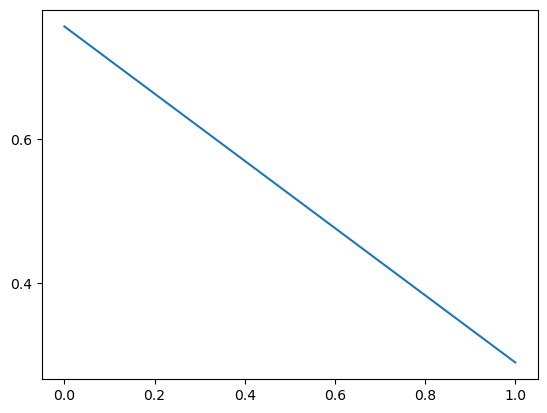

In [22]:
input_size = len(list(train_lp.source_char2id.keys()))
output_size = len(list(train_lp.target_char2id.keys()))

hidden_size = 128
batch_size = 64

num_encoder_layers = 2
num_decoder_layers = 2

bidirectional = True
teacher_forcing = True
teacher_forcing_ratio = 0.3

loss_criterion =  nn.CrossEntropyLoss(ignore_index=pad_token_id)

#loss_criterion = nn.NLLLoss(ignore_index=pad_token_id)
#loss_criterion = nn.NLLLoss(ignore_index=pad_token_id)

dropout=0.1

encoder = EncoderRNN(input_size = input_size, hidden_size = hidden_size,num_layers=num_encoder_layers,bidirectional=bidirectional,padding_idx=pad_token_id,dropout_p=dropout).to(device)
decoder = DecoderRNN(hidden_size = hidden_size, output_size = output_size,max_len = train_lp.max_len,start_token_id = start_token_id,num_layers = num_decoder_layers,bidirectional = bidirectional,padding_idx = None).to(device)

train(train_loader,valid_loader, encoder, decoder, 10,loss_criterion=loss_criterion, print_every=3, plot_every=5,device=device,teacher_forcing = teacher_forcing,teacher_forcing_ratio=teacher_forcing_ratio)

In [31]:
op1,_ = evaluate(encoder, decoder, word="srirama", language_processor=train_lp,device = device)

op2,_ = evaluate(encoder, decoder, word="tejasvi", language_processor=train_lp,device = device)

op1_string = "".join(op1)
print(op_string[:8])

op2_string = "".join(op2)
print(op2_string[:7])

print()


శ్రీరామా
తెజస్వి



### JV

###### To Do:

1. Add LSTM,RNN support : Train
2. Write code for attention.
3. Write code for beam search.
4. Now create a seq2seq class, specify attention = True for attention to work.